In [2]:
import torch as th
import numpy as np

if th.cuda.is_available():
    dev = th.device("cuda")

In [3]:
def rotation(theta):
    """Rotation matrix for a single qubit."""
    U = th.tensor(
            [[np.cos(theta / 2), -1j * np.sin(theta / 2)],
            [-1j * np.sin(theta / 2), np.cos(theta / 2)]],
            dtype=th.complex128)
    return U


def global_rotation(angles,N):
    """Apply a global rotation to the state vector."""

    U = rotation(angles[0])

    for i in range(1,N):
        U_i = rotation(angles[i])
        U = th.kron(U, U_i)
    return U


def cnot_gate(state, N, k):
    """Apply a CNOT gate to the state vector. The CNOT act on qubit k and k+1."""

    cnot = th.tensor([
                [1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 0, 1],
                [0, 0, 1, 0]
        ], dtype=th.complex128)
    
    p1 = k
    p2 = N-k-2

    Id1 = th.eye(2**p1, dtype=th.complex128)
    Id2 = th.eye(2**p2, dtype=th.complex128)

    cnot_matrix = th.kron(Id1, th.kron(cnot, Id2))
    
    return cnot_matrix @ state @ cnot_matrix.adjoint() 

In [4]:
def generate_ghz_state(N):
    """Generate a GHZ state for N qubits."""
    ghz_state = th.zeros(2**N, dtype=th.complex128)
    ghz_state[0] = 1 / th.sqrt(th.tensor(2.0, dtype=th.complex128))
    ghz_state[-1] = 1 / th.sqrt(th.tensor(2.0, dtype=th.complex128))
    return th.outer(ghz_state, ghz_state)


def generate_H(N):
    h = 9/N
    scale = 2**(N/2)

    Z = th.tensor([[1, 0], [0, -1]], dtype=th.complex128)

    ZZ = th.kron(Z, Z)

    H = th.zeros(2**N, 2**N, dtype=th.complex128)

    for i in range(N-1):
        H += th.kron( th.eye(2**i), th.kron(ZZ, th.eye(2**(N-i-2))) )

    return h*scale*H

In [39]:
def layer(state, angles, N):
    """Apply a layer of gates to the state vector."""
    U = global_rotation(angles,N)
    
    # Apply the rotation
    state = U @ state @ U.adjoint()
    
    # Apply CNOT gates
    for i in range(N-1):
        state = cnot_gate(state, N, i)
    
    return state

def calc_variance(N,L,p):
    n_sim = 2000

    ghz = generate_ghz_state(N)
    H = generate_H(N)

    obs = 0

    for _ in range(n_sim):
        state = th.zeros(2**N,2**N, dtype=th.complex128)
        state[0,0] = 1.0  # |000>

        params = np.random.uniform(0, np.pi, size=(L, N))

        # Sample whether to entangle or use CNOT at each layer
        entangle_flags = np.random.rand(L) < p  # Boolean array

        for i in range(L):
            state = p * ghz + (1-p) * layer(state, params[i], N)

        # Run the circuit
        obs += th.trace(state @ H).real
    
    return obs/n_sim

In [45]:
calc_variance(2, 3, 0.1)

tensor(0.9834, dtype=torch.float64)

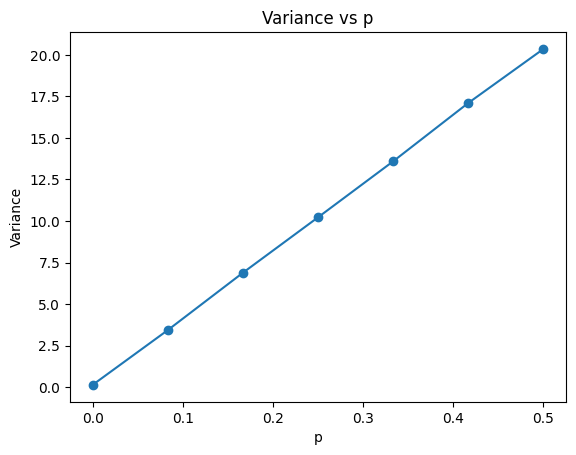

In [9]:
import matplotlib.pyplot as plt

ps = np.linspace(0, 0.5, 7)
variances = [calc_variance(5, 9, p) for p in ps]

plt.plot(ps, variances, marker='o')
plt.xlabel('p')
plt.ylabel('Variance')
plt.title('Variance vs p')
plt.show()